## Trabalho de Conclusão de Semestre - Redes Neurais e Algoritmos Genéticos
<p align = 'center'> <h2> Predições Climáticas: </h2></p>
<p align = 'center'> <h3> O uso de Redes Neurais para análise da influência de temperatura na superfície marítma em locais de ocorrência do fenômeno 'El Niño'</h3> </p>

#### Autores:
Alice Kageyama (220049), Haziel Sixto Baden Sanchez Hermoza (220065), Monyque Karoline de Paula Silva (220063), Pedro Thomazelli Ferreira (220058)

<hr>

In [ ]:
# Importações:

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import MeanAbsolutePercentageError

import pandas as pd
import matplotlib.pyplot as plt
import seabo

import shaprn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
# Setup inicial:

TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 61455
ARQUIVO = 'dados/elnino.csv'

df = pd.read_csv(ARQUIVO, header=0)
df = df.drop(columns=['Observation', ' Date'])

# Removendo dados faltantes:
df = df[df != '.']
df.dropna(how='any', inplace=True)
df = df.astype(float)
df = df.reset_index(drop=True)

display(df)

,Year,Month,Day,Latitude,Longitude,Zonal Winds,Meridional Winds,Humidity,Air Temp,Sea Surface Temp
0,93.0,5.0,9.0,-0.02,-109.96,-2.1,2.1,81.2,26.80,27.02
1,93.0,5.0,10.0,-0.02,-109.96,-3.4,1.4,84.2,26.95,26.91
2,93.0,5.0,11.0,-0.02,-109.96,-3.8,2.2,84.9,26.98,26.78
3,93.0,5.0,12.0,-0.02,-109.96,-3.0,1.5,86.9,26.93,26.74
4,93.0,5.0,13.0,-0.02,-109.96,-4.5,1.9,87.6,27.01,26.82
...,...,...,...,...,...,...,...,...,...,...
93930,98.0,6.0,10.0,8.95,-140.33,-6.8,-5.3,81.3,27.52,28.17
93931,98.0,6.0,11.0,8.96,-140.33,-5.1,-0.4,94.1,26.04,28.14
93932,98.0,6.0,12.0,8.96,-140.32,-4.3,-3.3,93.2,25.80,27.87
93933,98.0,6.0,13.0,8.95,-140.34,-6.1,-4.8,81.3,27.17,27.93


In [5]:
# Definindo os dados de treino e teste:

FEATURES = [df.columns[0],df.columns[1],df.columns[2],df.columns[3],df.columns[4],df.columns[5],df.columns[6],df.columns[7],df.columns[8]]
TARGET = [df.columns[9]]

indices = df.index

indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

x_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1)
x_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1)

In [6]:
# Normalização:

normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(x_treino)
normalizador_y.fit(y_treino)

x_treino = normalizador_x.transform(x_treino)
y_treino = normalizador_y.transform(y_treino)
x_teste = normalizador_x.transform(x_teste)
y_teste = normalizador_y.transform(y_teste)

In [7]:
# Criando tensores:

x_treino = torch.tensor(x_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)
x_teste = torch.tensor(x_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [8]:
# Checando os dados:

print(x_treino)
print()
print(y_treino)

tensor([[0.4444, 1.0000, 0.3000,  ..., 0.4110, 0.6862, 0.7207],
        [0.8889, 0.4545, 0.1667,  ..., 0.5169, 0.6130, 0.8314],
        [0.7778, 0.9091, 0.0000,  ..., 0.4195, 0.6841, 0.4884],
        ...,
        [0.4444, 0.3636, 0.4333,  ..., 0.3856, 0.7301, 0.6780],
        [0.8889, 0.6364, 0.0000,  ..., 0.3051, 0.6025, 0.7359],
        [0.3333, 0.4545, 0.9000,  ..., 0.4831, 0.6506, 0.5810]])

tensor([[0.8132],
        [0.8444],
        [0.4786],
        ...,
        [0.7121],
        [0.8444],
        [0.5377]])


In [9]:
# Criando a classe da rede neural:

class OS_MENININHOS(nn.Module):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        super().__init__()

        # Definindo as camadas da rede:
        
        self.camadas = nn.Sequential(
                    nn.Linear(num_dados_entrada, neuronios_c1),
                    nn.ReLU(),
                    nn.Linear(neuronios_c1, neuronios_c2),
                    nn.ReLU(),
                    nn.Linear(neuronios_c2, num_targets),
                )

    def forward(self, x):
        """ Esse é o método que executa a rede do pytorch."""
        x = self.camadas(x)
        return x

In [10]:
# Criando uma instância da rede:

NUM_DADOS_DE_ENTRADA = x_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 150
NEURONIOS_C2 = 63

minha_redezinha = OS_MENININHOS(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [11]:
# Checando os parâmetros internos:

for p in minha_redezinha.parameters():
    print(p)

Parameter containing:
tensor([[-0.0554,  0.2903, -0.2586,  ..., -0.0436, -0.1897,  0.0365],
        [ 0.3236, -0.2725,  0.2314,  ...,  0.0778, -0.2246, -0.0813],
        [-0.0729, -0.1300, -0.1962,  ...,  0.2477, -0.1530,  0.3020],
        ...,
        [ 0.1918, -0.0684,  0.0008,  ..., -0.1199, -0.1161, -0.1029],
        [ 0.1781, -0.2892, -0.3202,  ...,  0.2296,  0.0914, -0.0438],
        [ 0.2898, -0.0730,  0.2086,  ..., -0.2138,  0.0672, -0.2734]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0018,  0.2272, -0.0911,  0.0082,  0.0493, -0.0611,  0.0859, -0.2403,
        -0.2208, -0.1486,  0.2159,  0.3293, -0.0464,  0.2226, -0.2623, -0.1580,
        -0.0402,  0.0366,  0.2427, -0.2145,  0.0431,  0.2918,  0.1090, -0.0130,
         0.2000, -0.0387, -0.2368, -0.0367, -0.1687,  0.3270,  0.3201, -0.2223,
        -0.1253,  0.2458,  0.2926,  0.0015,  0.1184,  0.1119,  0.0048,  0.3047,
        -0.3076,  0.1637, -0.1836,  0.2898,  0.2436,  0.1813, -0.3252, -0.1808,
        -0.1902

In [12]:
# Primeiro teste de previsão (ruinzinha):

y_prev = minha_redezinha(x_treino)
y_prev

tensor([[-0.1846],
        [-0.2214],
        [-0.2072],
        ...,
        [-0.1820],
        [-0.2008],
        [-0.1983]], grad_fn=<AddmmBackward>)

In [13]:
# Usando o otimizador (Adam):

TAXA_DE_APRENDIZADO = 0.001

# A função perda será o erro quadrático médio:
fn_perda = nn.MSELoss()

# O otimizador será o Adam, um tipo de descida do gradiente:
otimizador = optim.Adam(minha_redezinha.parameters(), lr=TAXA_DE_APRENDIZADO)

In [14]:
# Treinando a rede:

# Colocando ela no "modo treino":
minha_redezinha.train()

NUM_EPOCAS = 1000

y_true = y_treino

for epoca in range(NUM_EPOCAS):
    # Forward pass:
    y_pred = minha_redezinha(x_treino)

    # Zero grad:
    otimizador.zero_grad()

    # Loss:
    loss = fn_perda(y_pred, y_true)

    # Backpropagation:
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # Exibe o resultado:
    print(epoca, loss.data)

0 tensor(0.9265)
1 tensor(0.8069)
2 tensor(0.6966)
3 tensor(0.5964)
4 tensor(0.5068)
5 tensor(0.4276)
6 tensor(0.3575)
7 tensor(0.2956)
8 tensor(0.2408)
9 tensor(0.1922)
10 tensor(0.1490)
11 tensor(0.1113)
12 tensor(0.0796)
13 tensor(0.0548)
14 tensor(0.0372)
15 tensor(0.0273)
16 tensor(0.0247)
17 tensor(0.0283)
18 tensor(0.0362)
19 tensor(0.0458)
20 tensor(0.0547)
21 tensor(0.0609)
22 tensor(0.0635)
23 tensor(0.0625)
24 tensor(0.0585)
25 tensor(0.0526)
26 tensor(0.0457)
27 tensor(0.0388)
28 tensor(0.0326)
29 tensor(0.0277)
30 tensor(0.0242)
31 tensor(0.0221)
32 tensor(0.0213)
33 tensor(0.0214)
34 tensor(0.0220)
35 tensor(0.0230)
36 tensor(0.0241)
37 tensor(0.0250)
38 tensor(0.0256)
39 tensor(0.0258)
40 tensor(0.0256)
41 tensor(0.0251)
42 tensor(0.0243)
43 tensor(0.0233)
44 tensor(0.0222)
45 tensor(0.0210)
46 tensor(0.0199)
47 tensor(0.0189)
48 tensor(0.0182)
49 tensor(0.0176)
50 tensor(0.0172)
51 tensor(0.0171)
52 tensor(0.0170)
53 tensor(0.0171)
54 tensor(0.0172)
55 tensor(0.0172)
56

In [15]:
# Checando a performance da rede:

with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_redezinha(x_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

for yt, yp in zip(y_true, y_pred):
    print(yt, yp)

[28.63999986] [28.44288277]
[29.03999988] [29.27822618]
[24.33999998] [24.37958922]
[25.92] [26.53563476]
[26.95000037] [27.00901601]
[29.14999973] [29.38783618]
[23.66999987] [23.68381629]
[28.01000028] [26.8866343]
[26.70000035] [26.56831348]
[28.88999987] [29.18933124]
[28.77000017] [27.9347525]
[30.2999998] [29.88812036]
[29.23999989] [29.09722174]
[23.83000011] [23.77068384]
[29.38000005] [29.35229674]
[29.44999975] [28.51621115]
[29.78000008] [29.69396432]
[28.88999987] [28.56213187]
[28.39999969] [28.44857278]
[25.58999968] [26.79114403]
[29.63999992] [29.67945627]
[28.63000001] [28.68431061]
[30.33000011] [29.89116872]
[25.31999997] [25.48680425]
[27.32000008] [27.90184706]
[27.58999979] [27.01291531]
[29.14999973] [29.66676881]
[24.36000006] [24.86002383]
[28.73999986] [28.47353717]
[28.58000001] [28.72422498]
[27.78999981] [27.36949764]
[29.54999976] [29.76591022]
[29.3899999] [29.48204813]
[28.02999997] [28.2898007]
[25.87] [26.12861201]
[25.02999979] [25.22071609]
[26.11000

In [16]:
# Testando a rede:

# Colocando ela no "modo avaliação":
minha_redezinha.eval()

with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_teste)
    y_pred = minha_redezinha(x_teste)
    y_pred = normalizador_y.inverse_transform(y_pred)

for yt, yp in zip(y_true, y_pred):
    print(yt, yp)

[26.97000006] [26.99314462]
[28.32999999] [29.20552432]
[28.78999987] [28.66092555]
[29.61000037] [29.70280916]
[27.27999993] [27.3578166]
[23.80000018] [23.28789632]
[27.72999996] [27.99194602]
[28.88000002] [29.49406464]
[29.23000005] [27.92327136]
[25.86000015] [25.17850626]
[29.01000034] [28.80029995]
[30.2999998] [30.11003947]
[29.18999989] [29.35064925]
[29.14999973] [29.53840144]
[28.43999985] [28.07992645]
[29.47000021] [29.12903115]
[29.06000034] [29.00164645]
[28.93000003] [28.72312818]
[29.4399999] [29.64085085]
[29.2700002] [29.48761024]
[29.90999963] [29.53475566]
[30.25999965] [30.1935676]
[29.54999976] [28.99953098]
[28.17000014] [28.95926199]
[28.71000032] [28.90933092]
[28.13999983] [27.60782581]
[29.71000038] [29.02066654]
[29.74999977] [29.85664413]
[28.93000003] [29.34179292]
[24.41999991] [24.39384758]
[23.23999992] [24.32352543]
[28.03999982] [28.2747205]
[29.18999989] [28.9785264]
[29.53999991] [29.22667059]
[27.5700001] [27.0691522]
[26.57000004] [26.64919154]
[

In [17]:
# Medindo a performance com RMSE:

RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(f'Loss do teste: {RMSE}')

Loss do teste: 0.42690475440931064


In [18]:
# Medindo a performance com MAPE:
target = torch.tensor([1, 10, 1e6])
preds = torch.tensor([0.9, 15, 1.2e6])
MAPE = MeanAbsolutePercentageError()
print(f'Loss do teste: {MAPE(preds, target)}')

Loss do teste: 0.2666666805744171


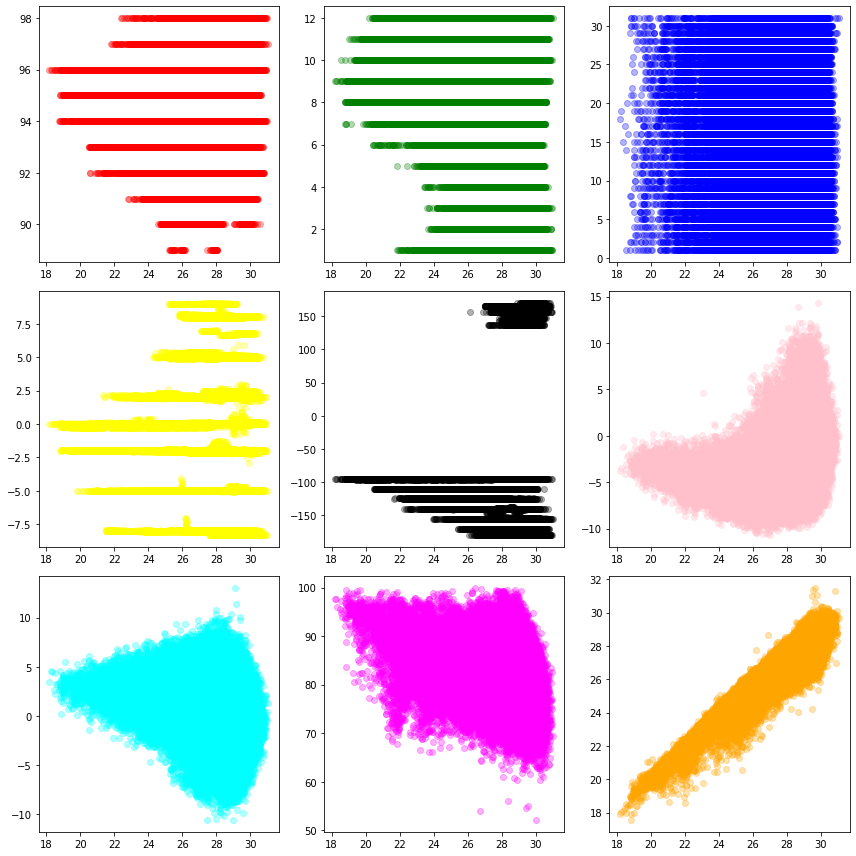

In [19]:
# Plotando scatter plots para cada feature em relação ao target:

fig, axs = plt.subplots(3,3,figsize = (12,12))
axs = axs.flatten()
for (i, ax), cor in zip(enumerate(axs),['r', 'g', 'b', 'yellow', 'k', 'pink', 'cyan', 'magenta', 'orange']):
    ax.scatter(list(df[TARGET[0]]), list(df[FEATURES[i]]), color=cor, alpha=0.3)
    
plt.tight_layout()
plt.show()

In [20]:
# Matriz de covâriancia
df_covariancia = df.cov()

# Matriz de correlação
df_correlacao = df.corr()

print('Matriz de covariância: ')
df_covariancia

print('\n\nMatriz de correlação: ')
df_correlacao

Matriz de covariância: 


Matriz de correlação: 


,Year,Month,Day,Latitude,Longitude,Zonal Winds,Meridional Winds,Humidity,Air Temp,Sea Surface Temp
Year,1.000000,-0.186230,-0.016503,0.022339,-0.034951,0.026287,-0.085108,-0.011785,0.055755,0.053689
Month,-0.186230,1.000000,0.013974,-0.001173,-0.008976,0.063149,0.265413,-0.132518,-0.134154,-0.098813
Day,-0.016503,0.013974,1.000000,-0.001630,-0.002007,0.005034,0.005668,-0.000252,-0.007448,-0.004826
Latitude,0.022339,-0.001173,-0.001630,1.000000,0.096651,0.117911,-0.092178,0.158111,0.076123,0.125119
Longitude,-0.034951,-0.008976,-0.002007,0.096651,1.000000,0.364256,-0.024335,-0.042777,0.249050,0.304027
Zonal Winds,0.026287,0.063149,0.005034,0.117911,0.364256,1.000000,0.079763,0.063553,0.233156,0.376015
Meridional Winds,-0.085108,0.265413,0.005668,-0.092178,-0.024335,0.079763,1.000000,0.077647,-0.339254,-0.284897
Humidity,-0.011785,-0.132518,-0.000252,0.158111,-0.042777,0.063553,0.077647,1.000000,-0.388059,-0.324348
Air Temp,0.055755,-0.134154,-0.007448,0.076123,0.249050,0.233156,-0.339254,-0.388059,1.000000,0.940233
Sea Surface Temp,0.053689,-0.098813,-0.004826,0.125119,0.304027,0.376015,-0.284897,-0.324348,0.940233,1.000000


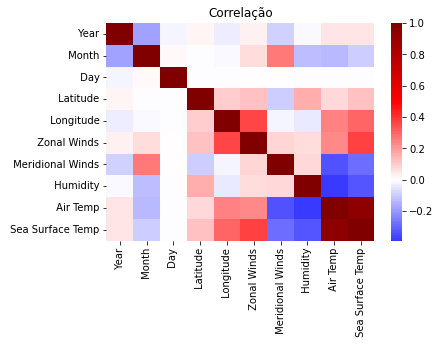

In [21]:
#Criando um mapa de cores dos valoes da correlação
sns.heatmap(df_correlacao, 
        xticklabels=df_correlacao.columns,
        yticklabels=df_correlacao.columns,
           cmap='seismic',
           center = 0)

plt.title('Correlação')
plt.show()

In [24]:
shap.summary_plot(shap_values, features=x_samples, feature_names=features)

NameError: name 'shap' is not defined

In [25]:
# Create a SHAP explainer
#explainer = shap.DeepExplainer(camadas, df)

# Calculate SHAP values for your dataset
shap_values = explainer.shap_values(df)

# Plot the feature importance using a summary plot
#shap.summary_plot(shap_values, df)

NameError: name 'explainer' is not defined